In [24]:
# Standard library
from scipy.optimize import curve_fit

# Third-party libraries
import gvar
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from pysr import PySRRegressor

# Local modules
from nuclr.fitting import (calculate_PCA, envelope, find_local_minima_maxima, get_nucl_range, 
                     get_range_dat, mask_uncertainities, PCA_fit, polynomial, preds_targets_zn, rms_val,
                     plot_task_vs_pc, plot_pc_vs_N, sweep_pca_components)
from nuclr.train import Trainer
from nuclr.data import semi_empirical_mass_formula

import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set()
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [3]:
model_path = "spiral"
trainer = Trainer.from_path(model_path)

No sn, sp or binding data, skipping leave one out


In [4]:
model = trainer.models[0].cpu()
task_names = list(trainer.data.output_map.keys())

magic_numbers = [2, 8, 20, 28, 50, 82, 126]
data = trainer.data

In [5]:
proton_embs, neutron_embs, task_embs = model.emb
proton_embs = proton_embs.weight.detach().cpu().numpy()
neutron_embs = neutron_embs.weight.detach().cpu().numpy()
task_embs = task_embs.weight.detach().cpu().numpy()

In [6]:
znt = data.X[data.X[:, 2] == task_names.index("binding_semf")]
znt_np = znt.cpu().detach().numpy()
embs = model.embed_input(znt, model.emb)

In [7]:
znt

tensor([[  9,   9,   0],
        [  9,  10,   0],
        [  9,  11,   0],
        ...,
        [117, 176,   0],
        [117, 177,   0],
        [118, 176,   0]])

In [8]:
pca = PCA(n_components=5)
embs_pca = pca.fit_transform(embs.detach().cpu().numpy())
print("PCA:", pca.explained_variance_ratio_, "\n")

PCA: [0.43621784 0.05249805 0.04981862 0.0392231  0.03871231] 



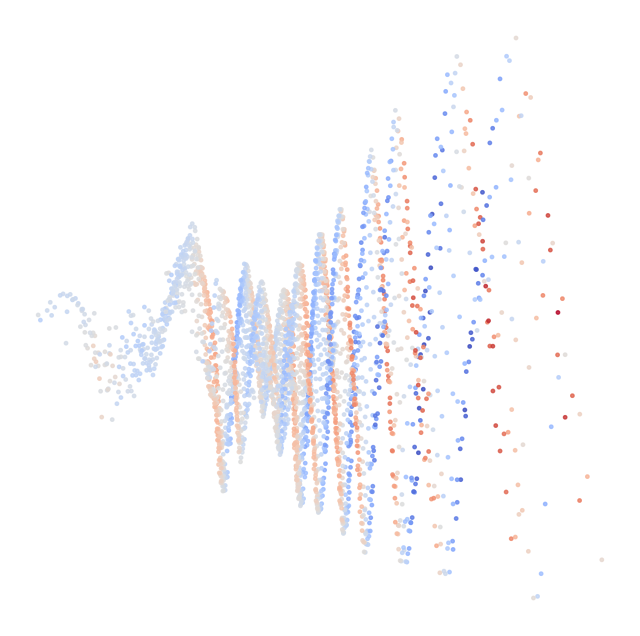

In [9]:
def scatter_2d_nuclei(x_axis_pc, y_axis_pc, color_pc):
    x = embs_pca[:, x_axis_pc]
    y = embs_pca[:, y_axis_pc]
    colors = embs_pca[:, color_pc]
    colors = (colors-min(colors))/(max(colors)-min(colors))
    colors = plt.cm.coolwarm(colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    for idx, coords in enumerate(zip(x, y)):
        zn = znt[idx, :2].cpu().numpy()
        #plt.text(coords[0], coords[1], f"{zn[0]}-{zn[1]}", fontsize=8, ha="center", va="center", color=colors[idx], alpha=0.5)
    plt.scatter(x, y, c=colors, alpha=0.8, s=6)

    plt.xlabel(f"PC{x_axis_pc+1}")
    plt.ylabel(f"PC{y_axis_pc+1}")
    plt.axis("off")
    plt.show()
    
for i in range(1):
    for j in range(i+1, 2):
        scatter_2d_nuclei(i, j, j+1)

## Plot task prediction vs PCA component keeping Z fixed.

Next:
- Color even and odd N.

---

PCA: [0.43487233 0.1046     0.09684525 0.06071955 0.0350069 ] 



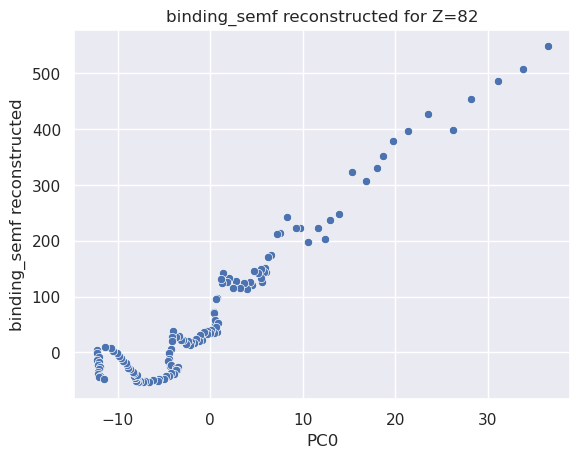

In [13]:
plot_task_vs_pc("binding_semf", Z_number=82, pca_comp=0, model=model, task_names=task_names, data=data);

## Plot RMS of reconstructed embeddings vs PCA number of components.


In [13]:
task_name = "binding_semf"
semf = semi_empirical_mass_formula(znt[:, 0], znt[:, 1]).cpu().numpy()
X, targets, preds = preds_targets_zn(model, data, task_name, train=True, val=True)

Number of Components: 2, Explained Variance: 0.4887159466743469

Number of Components: 3, Explained Variance: 0.5385345816612244

Number of Components: 4, Explained Variance: 0.5777578949928284

Number of Components: 5, Explained Variance: 0.6164699792861938

Number of Components: 6, Explained Variance: 0.6489895582199097

Number of Components: 7, Explained Variance: 0.6782318949699402

Number of Components: 8, Explained Variance: 0.7036283016204834

Number of Components: 9, Explained Variance: 0.7185128331184387

Number of Components: 10, Explained Variance: 0.7321746945381165

Number of Components: 11, Explained Variance: 0.7448394298553467

Number of Components: 12, Explained Variance: 0.7568933367729187

Number of Components: 13, Explained Variance: 0.7679934501647949

Number of Components: 14, Explained Variance: 0.7778735160827637

Number of Components: 15, Explained Variance: 0.7871423363685608

Number of Components: 16, Explained Variance: 0.7960816621780396

Number of Componen

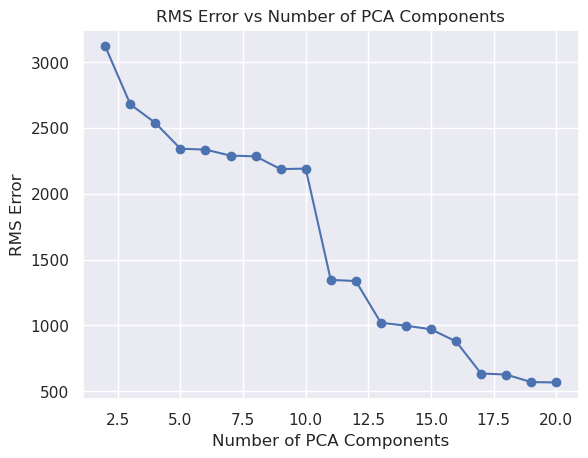

In [15]:
rms_results = sweep_pca_components(embs, targets, max_components=20, task_name=task_name, task_names=task_names, targets=targets, X=X, semf=semf)

In [16]:
rms_results

[3117.5545318633044,
 2677.84978577226,
 2536.4379921520667,
 2341.1213904980846,
 2334.4673536088603,
 2288.7373898580895,
 2283.234032615193,
 2186.240241221996,
 2190.241193684269,
 1345.3118772584905,
 1336.6501468545596,
 1020.1311972070389,
 997.727285669636,
 970.5627070468853,
 878.2321216717149,
 634.672578115238,
 626.7944606867385,
 569.7151066675874,
 566.7734933860236]

#### Fourier fitting

---

In [21]:
pcs_dic_params = {}

PCA: [0.43487233 0.10459998 0.09684528 0.06071951 0.03500691] 



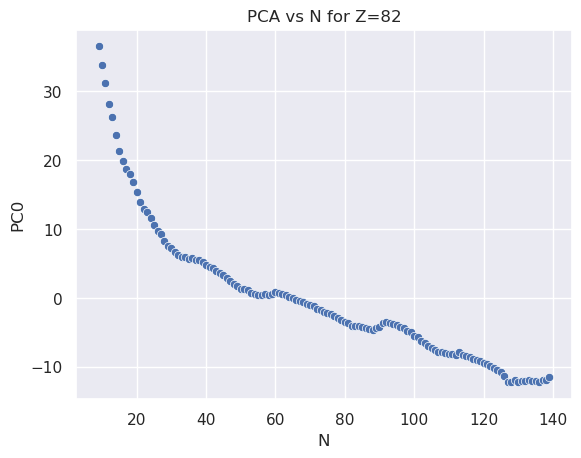

In [15]:
Xfit_N, Y_emb_comp = plot_pc_vs_N("binding_semf", Z_number=82, pca_comp=0, model=model, task_names=task_names, data=data)

PCA: [0.43487227 0.10459983 0.09684527 0.06071959 0.03500696] 



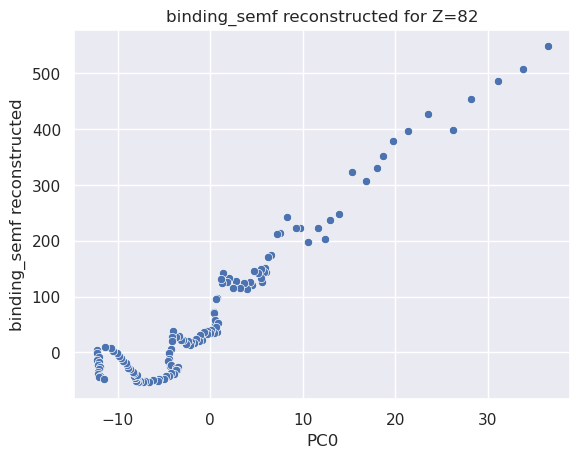

In [16]:
# We are fitting this, if you want to fit the plot above, change variables accordingly.

Xfit_pc, Y_bindings = plot_task_vs_pc("binding_semf", Z_number=82, pca_comp=0, model=model, task_names=task_names, data=data)

In [77]:
# Fourier

# Fourier series function
# N is the number of harmonics
# t is the independent variable
# *coeffs are the a0, a1, b1, a2, b2, ... coefficients
# Define the fundamental frequency
# You should adjust this based on your data's periodicity
def fourier_series(t, *coeffs):
    frequency = 0.1
    a0 = coeffs[0]
    result = a0
    num_harmonics = (len(coeffs) - 1) // 2
    for n in range(1, num_harmonics + 1):
        an = coeffs[2*n - 1]
        bn = coeffs[2*n]
        result += an * np.cos(n * frequency * t) + bn * np.sin(n * frequency * t)
    return result

def apply_fourier(X, Y, N_harmonics):
    # The number of harmonics you want to include
    # More harmonics can approximate more complex functions
    N_harmonics = N_harmonics
    # Initial guess for the coefficients (a0, a1, b1, a2, b2, ...)
    # You need 2*N_harmonics + 1 coefficients (including a0)
    initial_guess = [0] * (2 * N_harmonics + 1)

    # # Use curve_fit to find the best fit Fourier series
    params, params_covariance = curve_fit(
        fourier_series,
        X,
        Y,
        p0=initial_guess
    )

    # Use the optimized X to plot the fit
    fit_y = fourier_series(X, *params)

    return fit_y, params, params_covariance


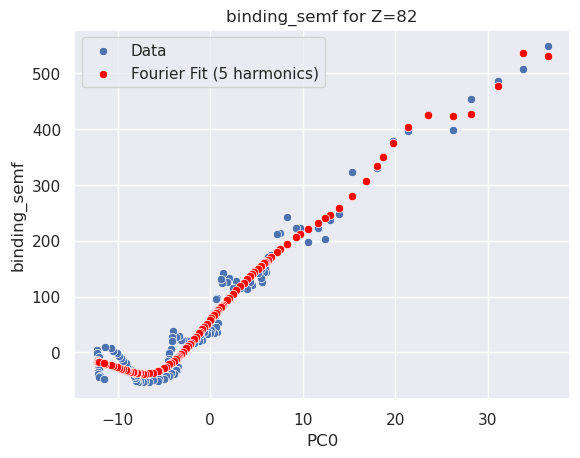

In [79]:
fit_y, params, params_covariance = apply_fourier(Xfit_pc, Y_bindings, N_harmonics=5)

sns.scatterplot(x=Xfit_pc, y=Y_bindings, label='Data')
sns.scatterplot(x=Xfit_pc, y=fit_y, label='Fourier Fit (5 harmonics)', color='red')
plt.xlabel('PC0')
plt.ylabel('binding_semf')
plt.title("binding_semf for Z=82")
plt.legend()
plt.savefig("plots/binding_vs_pc_fourier_fit_5.png", dpi=300)

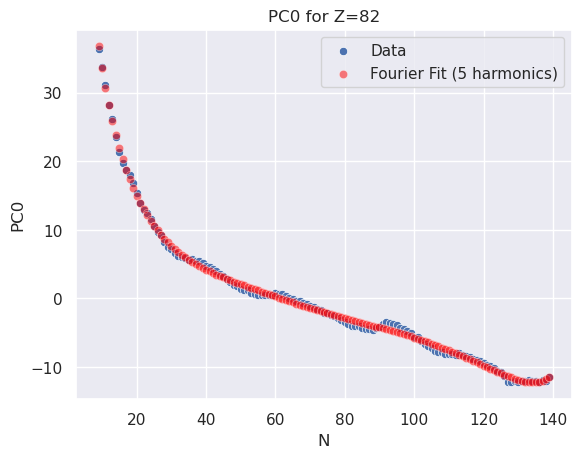

In [76]:
fit_y, params, params_covariance = apply_fourier(Xfit_N, Y_emb_comp, N_harmonics=5)

sns.scatterplot(x=Xfit_N, y=Y_emb_comp, label='Data')
sns.scatterplot(x=Xfit_N, y=fit_y, label='Fourier Fit (5 harmonics)', color='red',  alpha=0.5)
plt.xlabel('N')
plt.ylabel('PC0')
plt.title("PC0 for Z=82")
plt.legend()
plt.savefig("plots/pc_vs_N_fourier_fit_5.png", dpi=300)

In [48]:
# Saving parameters for each fit. Careful, you have to change it each time.

pcs_dic_params['pc0'] = params

In [49]:
# Saving parameters

#pd.DataFrame.from_dict(pcs_dic_params).to_csv('pcs_vs_N_fits_fourier_5.csv')
pd.DataFrame.from_dict(pcs_dic_params).to_csv('binding_vs_pc_5.csv')

In [26]:
# Saving frequencies

pcs_dic_freq = {}
pcs_dic_freq['freqs'] = [0.1]
pd.DataFrame.from_dict(pcs_dic_freq).to_csv('binding_vs_pc_freqs.csv')

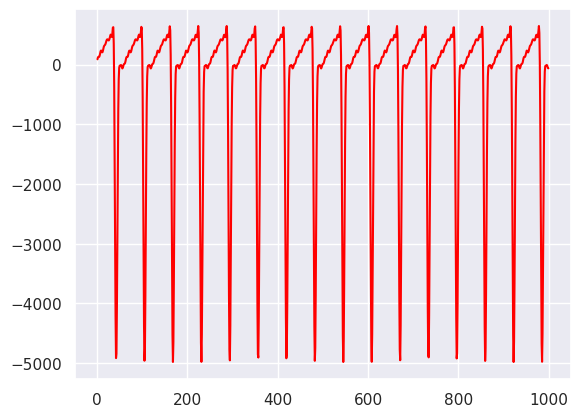

In [27]:
# Checking how the function looks in a bigger domain.

Xfit_test = np.arange(1,1000)
fit_y_test = fourier_series(Xfit_test, *params)
plt.plot(Xfit_test, fit_y_test, label='Fourier Fit', color='red')

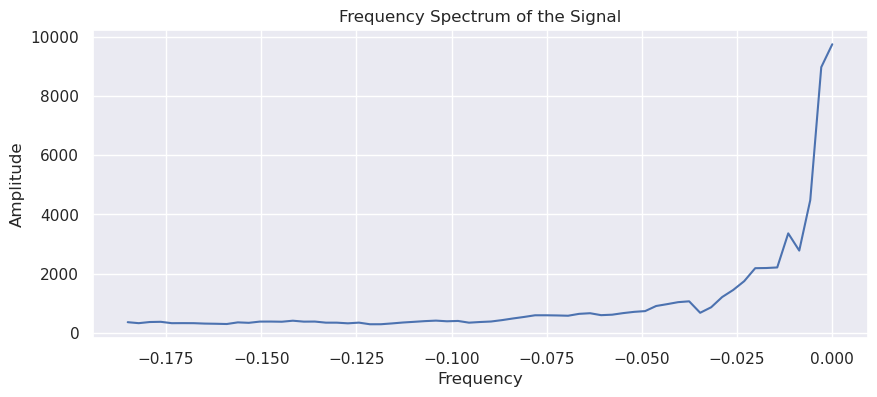

The dominant frequency is: -0.0 Hz


In [29]:
# Frequency analysis

# Calculate the sampling frequency
sampling_frequency = 1 / (Xfit_pc[1] - Xfit_pc[0])  # Assuming uniform spacing
N = len(Y_bindings)

# Compute the FFT
yf = np.fft.fft(Y_bindings)
xf = np.fft.fftfreq(N, 1 / sampling_frequency)

# The FFT output contains both positive and negative frequencies
# We are typically only interested in the positive frequencies, up to the Nyquist frequency
xf = xf[:N//2]
yf = np.abs(yf[:N//2])  # Get the absolute value since the FFT output is complex

# Find the peak frequency
dominant_frequency = xf[np.argmax(yf)]

# Plot the spectrum
plt.figure(figsize=(10, 4))
plt.plot(xf, yf)
plt.title("Frequency Spectrum of the Signal")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

print(f"The dominant frequency is: {dominant_frequency} Hz")


#### PySR
---

In [ ]:
def pysr_fit(X,y):

    model_pysr = PySRRegressor(
        procs=4,
        populations=8,
        # ^ 2 populations per core, so one is always running.
        population_size=60,
        # ^ Slightly larger populations, for greater diversity.
        ncyclesperiteration=10000, 
        # Generations between migrations.
        niterations=100,  # Run forever
        # early_stop_condition=(
        #     "stop_if(loss, complexity) = loss < 0.0001 && complexity < 15"
        #     # Stop early if we find a good and simple equation
        # ),
        timeout_in_seconds=60 * 60 * 24,
        # ^ Alternatively, stop after 24 hours have passed.
        maxsize=20,
        # ^ Allow greater complexity.
        maxdepth=10,
        # ^ But, avoid deep nesting.
        binary_operators=["*","/","+","-"],
        #, "A(x,y) = (abs(x+y))^(2/3)"
        # unary_operators=[
        #     "p2o3(x) = cbrt(square(abs(x)))",
        #     "pm1o3(x) = 1/(cbrt(abs(x)))",
        #     "square",       
        #     # ^ Custom operator (julia syntax)"square","cbrt",
        # ],
        #unary_operators=["sin", "cos", "sqrt"],
        #unary_operators=["square", "cube","exp","sin","square","log","sqrt"],
        unary_operators=["square", "cube","exp","sin","cos","tan","tanh","log","sqrt"],
        # constraints={"/": (5,3),
        #               "square": 3,
        #               "sin": 3
        #               },
        # nested_constraints={
        # "sin": {"exp":0,"sin":0,"tan":0,"tanh":0,"log":0,"sqrt":0},
        # "exp": {"exp":0,"sin":0,"tan":0,"tanh":0,"log":0,"sqrt":0},
        # "tan": {"exp":0,"sin":0,"tan":0,"tanh":0,"log":0,"sqrt":0},
        # "tanh": {"exp":0,"sin":0,"tan":0,"tanh":0,"log":0,"sqrt":0},
        # "log": {"exp":0,"sin":0,"tan":0,"tanh":0,"log":0,"sqrt":0},
        # "sqrt": {"exp":0,"sin":0,"tan":0,"tanh":0,"log":0,"sqrt":0}},
        nested_constraints={
            "sin": {"sin":3, "cos":3},
            "cos": {"cos":3},
            "cube": {"exp":1,"sin":1,"tan":1,"tanh":1,"log":1,"sqrt":1, "square":0, "cube":0},
            "square": {"exp":1,"sin":1,"tan":1,"tanh":1,"log":1,"sqrt":1, "square":0, "cube":0},
            },
        # constraints={
        # "/": (5,3),
        # # "p2o3": 3,
        # # "pm1o3": 3,
        # # "square": 3
        # },
        # ^ Nesting constraints on operators. For example,
        # "square(exp(x))" is not allowed, since "square": {"exp": 0}.
        # extra_sympy_mappings={"p2o3": lambda x: (abs(x))**(2/3),"pm1o3": lambda x: (abs(x))**(-1/3),
        #                       "inv": lambda x: 1/abs(x)},
        # ^ Define operator for SymPy as well
        complexity_of_constants=1,
        # ^ Punish constants more than variables
        weight_randomize=0.3,
        # ^ Randomize the tree much more frequently
        loss="loss(x, y) = (x - y)^2",
        # ^ Custom loss function (julia syntax)
    )
    X = X.reshape(-1, 1)
    model_pysr.fit(X, y)
    
    return model_pysr

In [181]:
model_pysr = pysr_fit(Xfit,Yfit)

/home/ubunsam/miniconda3/envs/nuclr_interp/lib/python3.11/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Expressions evaluated per second: 2.100e+05
Head worker occupation: 5.6%
Progress: 19 / 800 total iterations (2.375%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.103e+01  1.594e+01  y = -0.00013079
2           2.103e+01  5.960e-08  y = square(-0.002076)
3           2.075e+01  1.328e-02  y = (20.342 / x₀)
4           1.724e+01  1.852e-01  y = sin(x₀ * -0.37355)
5           1.611e+01  6.777e-02  y = tan(sin(-0.37386 * x₀))
6           1.484e+01  8.212e-02  y = cube(tan(sin(-0.37479 * x₀)))
7           1.183e+01  2.264e-01  y = (sin(x₀ * -0.37355) * cube(1.5808))
8           1.174e+01  7.899e-03  y = (sin(sin(x₀ * -0.37355)) * exp(1.5808))
9           1.174e+01  3.451e-05  y = (sin(sin(x₀ * sin(-0.38285))) * square(2.2071))
10          1.152e+01  1.928e-02  y = (sin((x₀ + sin(x₀)) * -0.37367) * cube(1.6402))
-----------------------------------------------

In [182]:
best_idx = model_pysr.equations_.query(
    f"loss < {2 * model_pysr.equations_.loss.min()}"
).score.idxmax()

In [ ]:
y_prediction = model_pysr.predict(Xfit.reshape(-1, 1), index=9)

plt.plot(Xfit, PCA_embs[:, pca_fit_nr], "o")
plt.plot(Xfit, y_prediction)

plt.show()
plt.clf()